In [1]:
import os
import cv2
import numpy as np 
import pandas as pd 
pd.options.mode.chained_assignment = None  

from PIL import Image
from tqdm import tqdm

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense,Flatten, Dropout
from sklearn.model_selection import train_test_split


# DataPaths

In [2]:
pathyes=[]
for dirname, _, filenames in os.walk('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'):
    for filename in filenames:
        k= os.path.join(dirname, filename)
        pathyes.append(k)
len(pathyes),pathyes[1]        

(155, '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y192.JPG')

In [3]:
pathno=[]
for dirname, _, filenames in os.walk('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'):
    for filename in filenames:
        k= os.path.join(dirname, filename)
        pathno.append(k)
len(pathno),pathno[1]        

(98, '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG')

# Create a data Frame with File paths and labels
* 1 --> Yes (Presence of Tumor)
* 0 --> No (Absence of tumor)

In [4]:
zero = [0]* len(pathno)
one = [1]*len(pathyes)


In [5]:
fn = pd.DataFrame(list(zip(pathno,zero )),
               columns =['filepath', 'label'])
fy = pd.DataFrame(list(zip(pathyes,one )),
               columns =['filepath', 'label'])

df = fn.append(fy,ignore_index = True )
df.head()


,filepath,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,0
1,/kaggle/input/brain-mri-images-for-brain-tumor...,0
2,/kaggle/input/brain-mri-images-for-brain-tumor...,0
3,/kaggle/input/brain-mri-images-for-brain-tumor...,0
4,/kaggle/input/brain-mri-images-for-brain-tumor...,0


In [6]:
df.tail()

,filepath,label
248,/kaggle/input/brain-mri-images-for-brain-tumor...,1
249,/kaggle/input/brain-mri-images-for-brain-tumor...,1
250,/kaggle/input/brain-mri-images-for-brain-tumor...,1
251,/kaggle/input/brain-mri-images-for-brain-tumor...,1
252,/kaggle/input/brain-mri-images-for-brain-tumor...,1


# Function to Resize all the images + Converting Image from BRG to Gray

Resize the images to a standard size (224x224) to ensure consistency and uniformity for further processing,Converting an image from BGR (Blue-Green-Red) to grayscale reduces its complexity by converting the color information into a single intensity channel

In [7]:
def load_and_resize_images(file_paths, size=(224, 224)):
    images = []
    for file_path in file_paths:
        img = Image.open(file_path)
        img = img.resize(size)
        img_array = np.asarray(img)
        images.append(img_array)
    return images

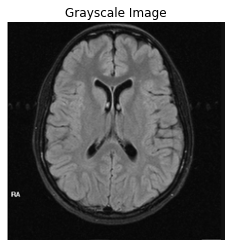

(224, 224)


In [8]:
# Load and resize images
no_images = load_and_resize_images(pathno)
yes_images = load_and_resize_images(pathyes)

# Combine images into a single list
all_images = no_images + yes_images

# Create a DataFrame and store the images
df = pd.DataFrame({"Imagearr": all_images})

# Now let's process one of the images
o = df.Imagearr[5]

# Ensure o is a NumPy array and convert to uint8 if necessary
if not isinstance(o, np.ndarray):
    o = np.array(o)
if o.dtype != np.uint8:
    o = o.astype(np.uint8)

# Convert to grayscale
og = cv2.cvtColor(o, cv2.COLOR_BGR2GRAY)

# Display the grayscale image using matplotlib
plt.imshow(og, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')  # Hide the axis
plt.show()

print(og.shape)

# Feature Detection using Filters


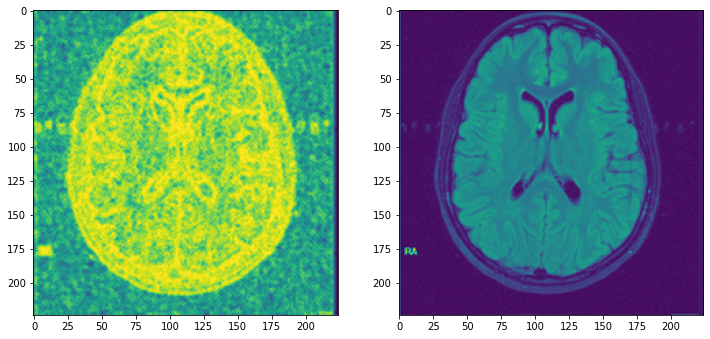

In [9]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

entropy_img = entropy(og,disk(2))

fig = plt.figure(figsize = (12,12)) 
ax1 = fig.add_subplot(121)# left side
ax2 = fig.add_subplot(122)

ax1.imshow(entropy_img)
ax2.imshow(og)
plt.show()

# Gaussian Filter
Basically Blurs the image

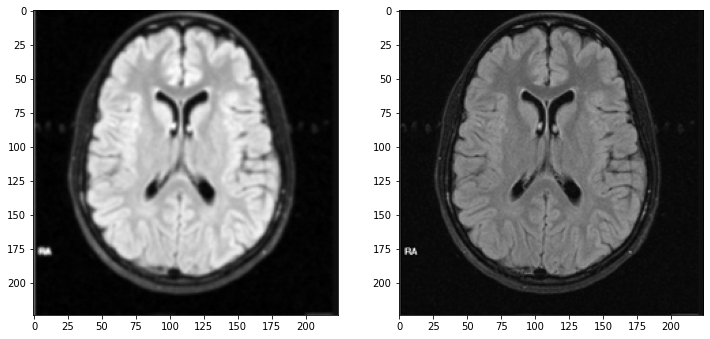

In [10]:
from scipy import ndimage as nd
from scipy import misc

fig = plt.figure(figsize = (12,12))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121) # On the Left
ax2 = fig.add_subplot(122) # Right Side
gaussian_img = nd.gaussian_filter(og,sigma = 1)
ax1.imshow(gaussian_img)
ax2.imshow(og)
plt.show()


# Sobel Filter

Helps to enhance the edges

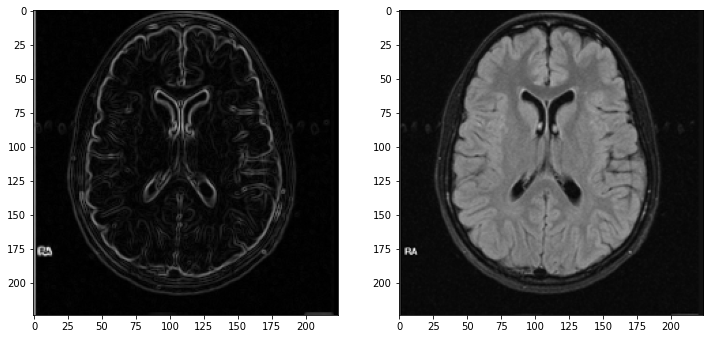

In [11]:
from skimage.filters import sobel

sobel_img = sobel(og)

fig = plt.figure(figsize = (12,12))
  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)# left side
ax2 = fig.add_subplot(122)

ax1.imshow(sobel_img)
ax2.imshow(og)
plt.show()

# Laplace Filter

<function matplotlib.pyplot.show(close=None, block=None)>

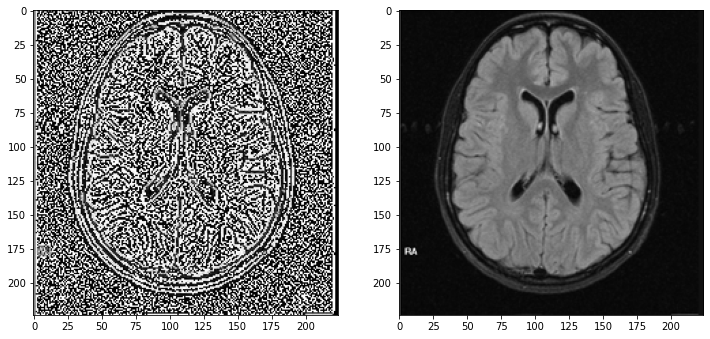

In [12]:
from scipy.ndimage import laplace

laplace_img = laplace(og)
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(laplace_img)
ax2.imshow(og)
plt.show

# Prewitt
Find the edge magnitude using the Prewitt transform.

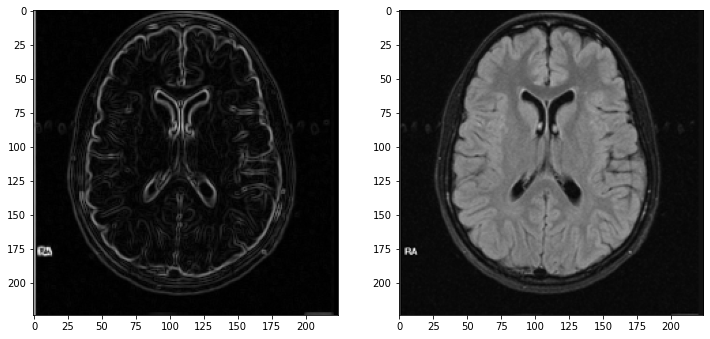

In [13]:
from skimage.filters import prewitt

prewitt_img = prewitt(og)
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(prewitt_img)
ax2.imshow(og)

plt.show()

# Convolutional Neural Network

# Normal cells

In [14]:
normal_cells=os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no')

print(normal_cells[0:5])

['34 no.jpg', 'N20.JPG', 'N1.JPG', '49 no.jpg', 'N15.jpg']


# Tumor Cells

In [15]:
tumor_cells=os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes')

print(tumor_cells[0:5])

['Y115.JPG', 'Y192.JPG', 'Y162.jpg', 'Y9.jpg', 'Y108.jpg']


**Make labels:**

In [16]:
normal_label=[0]*98
tumor_label=[1]*155

print('Normal Cell labels: ',len(normal_label))
print('Tumor Cell labels: ',len(tumor_label))

Normal Cell labels:  98
Tumor Cell labels:  155


In [17]:
print('With Normal labels: ',normal_label[0:5])
print('With Tumor labels: ',tumor_label[0:5])

With Normal labels:  [0, 0, 0, 0, 0]
With Tumor labels:  [1, 1, 1, 1, 1]


**Combining both labels into a single column**

In [18]:
labels=normal_label+tumor_label

print('Total labels are: ',len(labels))

print(labels[0:5])
print(labels[-5:])

Total labels are:  253
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]


In [19]:
normal_path=('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/')
data=[]

for img_file in normal_cells:
    image=Image.open(normal_path + img_file)
    image=image.resize((128,128))
    image=image.convert('RGB')
    image=np.array(image)
    data.append(image)
    
tumor_path=('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/')

for img_file in tumor_cells:
    image=Image.open(tumor_path + img_file)
    image=image.resize((128,128))
    image=image.convert('RGB')
    image=np.array(image)
    data.append(image)

# Converting data and labels into numpy array¶

In [20]:
X=np.array(data)
Y=np.array(labels)

In [21]:
print(X.shape)
print(Y.shape)

(253, 128, 128, 3)
(253,)


# **Train Test Split**

In [22]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=101)

In [23]:
print(X.shape,X_train.shape,X_test.shape)

(253, 128, 128, 3) (202, 128, 128, 3) (51, 128, 128, 3)


**Scaling the data**

In [24]:
X_train=X_train/255
X_test=X_test/255

X_train[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

# **a) Model Building**

In [25]:
num_of_classes=2

model=Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_of_classes, activation='sigmoid'))

compiling the model

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

training the model

In [27]:
history=model.fit(X_train,Y_train, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
6/6 [==============================] - 9s 75ms/step - loss: 5.9308 - accuracy: 0.5525 - val_loss: 3.1732 - val_accuracy: 0.5238
Epoch 2/50
6/6 [==============================] - 0s 23ms/step - loss: 1.8757 - accuracy: 0.7017 - val_loss: 0.4222 - val_accuracy: 0.8095
Epoch 3/50
6/6 [==============================] - 0s 23ms/step - loss: 0.7019 - accuracy: 0.7127 - val_loss: 0.4368 - val_accuracy: 0.8095
Epoch 4/50
6/6 [==============================] - 0s 23ms/step - loss: 0.3911 - accuracy: 0.8343 - val_loss: 0.5256 - val_accuracy: 0.7619
Epoch 5/50
6/6 [==============================] - 0s 23ms/step - loss: 0.2427 - accuracy: 0.9006 - val_loss: 0.3679 - val_accuracy: 0.9048
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 0.1664 - accuracy: 0.9613 - val_loss: 0.3673 - val_accuracy: 0.9048
Epoch 7/50
6/6 [==============================] - 0s 23ms/step - loss: 0.1072 - accuracy: 0.9724 - val_loss: 0.2260 - val_accuracy: 0.9048
Epoch 8/50
6/6 [===========

Accuracy/loss Curve

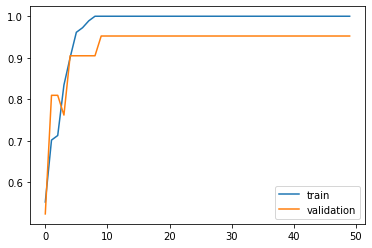

In [28]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')



plt.legend()
plt.show()

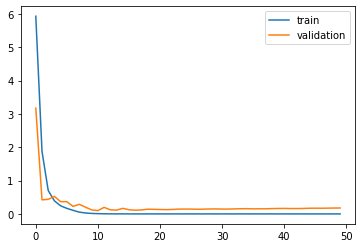

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.legend()
plt.show()

# **Prediction:**

In [30]:
input_image_path=input('Enter the path of the image: ')

input_image=cv2.imread(input_image_path)

plt.imshow(input_image)
plt.show()


# Ensure the shape matches the expected input shape of your model
input_image_reshape=cv2.resize(input_image,(128,128))


# Normalize the pixel values
image_normalized=input_image_reshape/255


# Reshape for model prediction
img_reshape=np.reshape(image_normalized,(1,128,128,3))


# Make Predictions
input_prediction=model.predict(img_reshape)

# Display the prediction Probabilities
print('Prediction Probabilities are:  ',input_prediction)


# Get the Predicted Label
input_pred_label=np.argmax(input_prediction)


if input_pred_label ==1:
    print('Tumor Cell')
else:
    print('Normal Cell')

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [ ]:
model.save('/kaggle/working/tumor_detection.h5')